# Coursera Capstone Project - Filling Barons Quay #

### The problem ###

Northwich is a town with a population of ~75,000 in Cheshire, England. Cheshire West and Chester Council (CWaCC) recently invested £80m to develop the Barons Quay shopping centre with brand-new, glass-fronted retail units in order to inject life into the sleepy town centre - encouraging locals to shop closer to home and those further afield to travel to this new hub.

Unfortunately, as of May 2019, 40% of the retail space remains unused. Walking through the area it's easy to see the vision the council had, but with several units bare and few prospective tenants, the development isn't living up to its potential.

With reported loan interest payments of £40,000 per week, CWaCC should have great interest in finding prospective tenants for Barons Quay; the sooner the available units are filled and the shopping centre is alive with business, the sooner the CWaCC see a positive return on their investment and the growth they want for this town.

To see where Northwich can improve as a retail hub, we need to look outwards towards other towns in England. By analysing which businesses operate in other towns but don't have a presence in Northwich, CWaCC will better understand what the town lacks and who they could approach to fill retail units.

### The data ###

Wikipedia conveniently [lists hundreds of English towns](https://en.wikipedia.org/wiki/List_of_towns_in_England) that can be compared to Northwich. Each town links to its own Wikipedia article, wherein population statistics are held within the key facts sidebar and location datapoints are tagged <span class="geo"> in the page source.

Cycling through the list, it's possible to extract population, latitude and longitude values to find other large towns in England and store them in a Pandas dataframe. With the location data, we can make API calls to Foursquare to discover businesses with a significant retail presence in multiple areas. This will generate a new dataframe with company names.

Given the goal of developing the town, it's appropriate to use much higher upper population bounds than lower bounds. In order to improve Northwich, Cheshire West and Chester Council ought to be trying to pull potential shoppers from larger towns and to do that they need similar attractions. We'll therefore be concentrating on the towns with the largest populations rather than focusing on too many towns with a smaller population.

With a list of potential tenants for Barons Quay and the shopping centre's latitude and longitude values, Foursquare API calls can again be used to find the distance of the nearest location for each business. The final result will be a comprehensive dataframe detailing business names, their commonness in other towns, and how far away their nearest presence is.

In [1]:
# import a few relevant packages for creating our dataframes

import pandas as pd
import requests
import numpy as np

In [2]:
towns_df = pd.DataFrame(columns = ["Town", "Population", "Latitude", "Longitude"]) # create an empty dataframe to add rows to

towns_df.head()

,Town,Population,Latitude,Longitude


In [3]:
towns_list_df = pd.DataFrame(columns = ["Town", "Link"]) # create an empty dataframe to add rows to

url_prefix = "https://en.wikipedia.org" # set a variable to which we can append the town links

town_list_url = "https://en.wikipedia.org/wiki/List_of_towns_in_England" # set wiki page as a variable

town_list_raw_page = requests.get(town_list_url).text # pull the HTML of the wiki page and convert it to a text string

Start = town_list_raw_page.find("<tbody>") # find the approximate start of the town tables

End = town_list_raw_page.find("<h2>", Start) # find the approximate end of the town tables

page = town_list_raw_page[Start:End] # slice the page to remove unnecessary data

In [4]:
while page.find("<tr>") > -1: # while there are still table rows in the segment
    
    link_start = page.find("/wiki") # find the start of the link
    
    link_end = page.find("\"", link_start) # find the end of the link
    
    Link = page[link_start:link_end] # slice the link from the extract
    
    town_start = page.find(">", link_end) + 1 # find the start of the town name
    
    town_end = page.find("<", town_start) # find the end of the town name
    
    Town = page[town_start:town_end] # slice the town name from the extract
    
    if Town != "Northwich": # if the town is Northwich, we're not interested - we can't compare Northwich to itself
        
        towns_list_df = towns_list_df.append({"Town":Town, "Link":Link}, ignore_index = True) # add the row to the dataframe
    
    page = page[page.find("<tr>", town_end):] # whittle down the page extract to start on the next row
       
towns_list_df.head()

,Town,Link
0,Abingdon-on-Thames,/wiki/Abingdon-on-Thames
1,Accrington,/wiki/Accrington
2,Acle,/wiki/Acle
3,Acton,"/wiki/Acton,_London"
4,Adlington,"/wiki/Adlington,_Lancashire"


We now have a list of towns and links via which we can extract their population.

Now we need to scrape the individual pages for their population values.

In [5]:
for index in towns_list_df.index: # iterate through each item in the dataframe
    
    Town = towns_list_df.iloc[index][0] # extract the town value and assign it to a variable so we can use it later
    
    Link = url_prefix + towns_list_df.iloc[index][1] # add the link portion of the dataframe to our predefined prefix
    
    town_raw_page = requests.get(Link).text # pull the HTML of the wiki page and convert it to a text string
    
    try: # first check for "Population</th><td>", which seems to be the most common format for population on Wikipedia
        
        population_slice = town_raw_page[town_raw_page.find("Population</th><td>")+19:town_raw_page.find("Population</th><td>")+40] # cut out a rough section detailing the population
        
        Population = int(population_slice[:population_slice.find("&")].replace(",", "")) # extract the number from the slice, remove any commas and cast to integer
        
    except ValueError: # if "Population</th><td>" is not found
        
        try: # check for "Population <div style" then "</th><td>" then "</td>" instead
            
            pop_start = town_raw_page.find("Population <div style") # find the start of the section detailing town population
            
            population_slice = town_raw_page[town_raw_page.find("</th><td>", pop_start)+9:town_raw_page.find("</th><td>", pop_start)+40] # cut out a rough section detailing the population
            
            Population = int(population_slice[:population_slice.find("</td>")].replace(",", "")) # extract the number from the slice, remove any commas and cast to integer
            
        except ValueError: # if "</td>" is not found
            
            try: # check for "Population <div style" then "</th><td>" a trailing space instead
                   
                pop_start = town_raw_page.find("Population <div style") # find the start of the section detailing town population
            
                population_slice = town_raw_page[town_raw_page.find("</th><td>", pop_start)+9:town_raw_page.find("</th><td>", pop_start)+40] # cut out a rough section detailing the population
            
                Population = int(population_slice[:population_slice.find(" ")].replace(",", "")) # extract the number from the slice, remove any commas and cast to integer
            
            except ValueError: # if none of the above formats are found, the page isn't likely for a large enough town, so we'll ignore it and load with the value "ERROR" instead
            
                Population = "ERROR" # set population to a clear, non-numerical value to remove later
            
                print("No population value found for", Town) # show which towns have no clear population, to check manually for any glaring ommissions
            
    latlong_slice = town_raw_page[town_raw_page.find("<span class=\"geo\">")+18:town_raw_page.find("<span class=\"geo\">")+75] # cut out a rough section detailing the location data
    
    Latitude = latlong_slice[:latlong_slice.find(";")] # extract the latitude from the slice
    
    Longitude = latlong_slice[latlong_slice.find(";")+2:latlong_slice.find("<")] # extract the longitude from the slice
    
    towns_df = towns_df.append({"Town":Town, "Population":Population, "Latitude":Latitude, "Longitude":Longitude}, ignore_index = True) # add the new row to the dataframe
    
towns_df.head()

No population value found for Ashby Woulds
No population value found for Barking
No population value found for Bexley
No population value found for Blackwater and Hawley
No population value found for Braunstone Town
No population value found for Broadstairs and St Peter's
No population value found for Bude-Stratton
No population value found for Chingford
No population value found for Corringham
No population value found for Dartford
No population value found for Dovercourt
No population value found for Finchley
No population value found for Great Torrington
No population value found for Harlow
No population value found for Harworth and Bircotes
No population value found for Heathfield
No population value found for Hendon
No population value found for Ipswich
No population value found for Liskeard
No population value found for Lytchett Minster &amp; Upton
No population value found for Newlyn
No population value found for Northleach with Eastington
No population value found for Ollerton 

,Town,Population,Latitude,Longitude
0,Abingdon-on-Thames,33130,51.667,-1.283
1,Accrington,35456,53.75337,-2.36384
2,Acle,2824,52.638,1.555
3,Acton,62480,51.513519,-0.270661
4,Adlington,6010,53.616546,-2.598583


In [6]:
towns_df.shape

(965, 4)

With over 900 successfully-extracted towns, I'm happy not to worry about any of those towns with no population value.

Let's ignore those instead by removing rows with an ERROR value.

In [7]:
towns_df = towns_df[towns_df["Population"] != "ERROR"].reset_index(drop = True)

towns_df.shape

(933, 4)

With 933 towns to consider, we can safely consider the 100 towns with the highest population.

In [8]:
top100 = towns_df.sort_values(["Population"], ascending = False).reset_index(drop = True).head(100) # sort by population (descending) and limit to 100

print(top100.head()) # check towns 1-5

print(top100.tail()) # check towns 96-100

          Town Population    Latitude   Longitude
0  Northampton     225700  52.2303748  -0.8937527
1        Luton     214700      51.883      -0.417
2   Warrington     209700    53.39167    -2.59722
3  Bournemouth     183491    50.72000    -1.88000
4      Swindon     182441       51.56       -1.78
             Town Population Latitude Longitude
95    Stourbridge      63298  52.4575   -2.1479
96      Rochester      62982   51.375     0.500
97       Dewsbury      62945   53.691    -1.633
98         Woking      62796  51.3162    -0.561
99  Sittingbourne      62500    51.34      0.74


A population range of 62500 to 225700 seems reasonable. This is 83% to 301% of Northwich's population.

### Foursquare population data ###

With 100 towns and their approximate latitude/longitude values, we can now leverage the Foursquare API to generate a list of retailers in each town.

In [9]:
CLIENT_ID = "#####" # personal information redacted
CLIENT_SECRET = "#####" # personal information redacted
VERSION = "20180605"

In [10]:
RADIUS = "3000" # check for retailers within 3000 metres of the given latitude/longitude

LIMIT = "300" # an arbitrary large limit of venues to return - Foursquare will probably return fewer matches

CATEGORIES = "4d4b7105d754a06378d81259,4d4b7105d754a06374d81259" # the category IDs for shop & service (4d4b7105d754a06378d81259) and food (4d4b7105d754a06374d81259)

In [11]:
retailers_df = pd.DataFrame(columns = ["Town", "Name", "Type"]) # create an empty dataframe to add rows to

In [12]:
for index in top100.index: # for each town in top100
    
    Town = top100.iloc[index][0] # extract the town name and set it to a variable
    LAT = top100.iloc[index][2] # extract the latitude and set it to a variable
    LONG = top100.iloc[index][3] # extract the longitude and set it to a variable
    
    # contruct a URL with our variables
    url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}".format(CLIENT_ID, CLIENT_SECRET, VERSION, LAT, LONG, RADIUS, LIMIT, CATEGORIES)
    
    venues = requests.get(url).json() # make the API call for this town and set the response to varible "venues"
    
    list = range(0, len(venues["response"]["groups"][0]["items"])) # generate a list for the number of venues returned
    
    for i in list: # for each venue returned
        
        Name = venues["response"]["groups"][0]["items"][i]["venue"]["name"] # extract the venue name and set it to a variable
        
        Type = venues["response"]["groups"][0]["items"][i]["venue"]["categories"][0]["shortName"] # extraxt the venue type and set it to a variable
        
        retailers_df = retailers_df.append({"Town":Town, "Name":Name, "Type":Type}, ignore_index = True) # add the new row to the dataframe
        
print("Venue data acquired.")

Venue data acquired.


We should now have a list of retailers with a food/shopping presence in the "top 100" towns we're focusing on.

In [13]:
retailers_df

,Town,Name,Type
0,Northampton,St Giles Cheese,Cheese Shop
1,Northampton,Aldi,Supermarket
2,Northampton,Vintage Retreat,Antiques
3,Northampton,HomeSense,Furniture / Home
4,Northampton,Waitrose & Partners,Supermarket
5,Northampton,Wilko,Furniture / Home
6,Northampton,Waterstones,Bookstore
7,Northampton,Daily Bread Food Cooperative,Grocery Store
8,Northampton,Co-op Food,Grocery Store
9,Northampton,Lidl,Supermarket


### Data cleansing ###

In [14]:
retailers = retailers_df # for safety, maintain retailers_df as unprocessed

Often the town name appears in the venue name. To group retailers in separate towns together, this is best extracted. 

In [15]:
for i in retailers.index: # for each retailer in the dataframe
    
    # switch the characters to uppercase, remove the town name if it's in the retailer name, then strip any leading/trailing spaces left as a result
    retailers.iloc[i][1] = retailers.iloc[i][1].upper().replace(retailers.iloc[i][0].upper(), "").strip()

Several retailers have different store types that serve a largely similar role, e.g. Sainsbury's have stores known as Sainsbury's Local. If we cut these down to their core company, we'll reduce duplicate entries recorded with different names.

In [16]:
big_stores = ["ASDA", "B&M", "M&S", "MORRISONS", "SAINSBURY'S", "TESCO", "VISION EXPRESS"] # create a list of likely candidates

for i in retailers.index: # for each retailer in the dataframe
    
    for store in big_stores: # for each of the stores in big_stores
        
        if store in retailers.iloc[i][1]: # if there's a character match with the big_stores entry
            
            retailers.iloc[i][1] = store # set the store name to the match in big_stores
            
    if retailers.iloc[i][1] == "M&S": # if the store name is "M&S"
        
        retailers.iloc[i][1] = "MARKS & SPENCER" # set "M&S" to the full name "MARKS & SPENCER"

In [17]:
retailers

,Town,Name,Type
0,Northampton,ST GILES CHEESE,Cheese Shop
1,Northampton,ALDI,Supermarket
2,Northampton,VINTAGE RETREAT,Antiques
3,Northampton,HOMESENSE,Furniture / Home
4,Northampton,WAITROSE & PARTNERS,Supermarket
5,Northampton,WILKO,Furniture / Home
6,Northampton,WATERSTONES,Bookstore
7,Northampton,DAILY BREAD FOOD COOPERATIVE,Grocery Store
8,Northampton,CO-OP FOOD,Grocery Store
9,Northampton,LIDL,Supermarket


Now the retailer names are largely standardised, they can be grouped to obtain a count of each retailer within 3km of our top 100 towns.

In [18]:
# create a new dataframe from the "Name" column, count the instances of each value, then set the dataframe to have headers "Retailer" and "Count"

retailers_grouped = pd.DataFrame(data = retailers["Name"].value_counts()).reset_index().rename(columns = {"index":"Retailer", "Name":"Count"})

retailers_grouped.head(10)

,Retailer,Count
0,TESCO,403
1,CO-OP FOOD,293
2,SAINSBURY'S,209
3,BOOTS,150
4,MARKS & SPENCER,135
5,WHSMITH,129
6,ARGOS,119
7,LIDL,116
8,ASDA,110
9,ALDI,101


In [19]:
retailers_grouped = retailers_grouped[retailers_grouped["Retailer"] != "MARKET"].reset_index(drop = True) # drop the MARKET row, as it's irrelevant

retailers_grouped.shape

(2302, 2)

We've obtained a dataframe of 2302 retailers and how many locations they have near our top 100 towns.

As we're only interested in popular retailers with a nationwide presence, we can cut these down by the Count value.

In [20]:
# extract only retailers with a Count of 10 or more
retailers_grouped = retailers_grouped[retailers_grouped["Count"] > 9].reset_index(drop = True)

retailers_grouped.shape

(97, 2)

This gives us 97 retailers with 10 or more stores - a good sample!

Now for each of these retailers, we can plug the name back into a Foursquare API search with Barons Quay as the location. This will give us the distance in metres to the closest retail presence for that business.

In [21]:
# import numpy for NULL values

import numpy as np

In [22]:
retailers_grouped["Closest"] = np.nan # create a new blank column to add the metre distance to
retailers_grouped["Popularity"] = np.nan # create a new blank column to add normalised values to
retailers_grouped["Distance"] = np.nan # create a new blank column to add normalised values to

retailers_grouped.head()

,Retailer,Count,Closest,Popularity,Distance
0,TESCO,403,NaN,NaN,NaN
1,CO-OP FOOD,293,NaN,NaN,NaN
2,SAINSBURY'S,209,NaN,NaN,NaN
3,BOOTS,150,NaN,NaN,NaN
4,MARKS & SPENCER,135,NaN,NaN,NaN


In [23]:
LAT = "53.2632568" # latitude of Barons Quay
LONG = "-2.5121776" # Longitude of Barons Quay
LIMIT = "10" # a limit of 10, to give the best chance of finding the closest instance in a Foursquare search

In [24]:
for i in retailers_grouped.index: # for each business in the dataframe
    
    distances = [] # create a blank list to add distances to
    
    QUERY = retailers_grouped["Retailer"][i] # set QUERY to be equal to the business name
    
    # generate a URL with our current variables
    search_url = "https://api.foursquare.com/v2/search/recommendations?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&limit={}&sortByDistance=true".format(CLIENT_ID, CLIENT_SECRET, VERSION, LAT, LONG, QUERY, LIMIT)
    
    search = requests.get(search_url).json() # make the API call for this URL and set the result to a variable
    
    for x in range(0, len(search["response"]["group"]["results"])): # for each search result
        
        Distance = search["response"]["group"]["results"][x]["venue"]["location"]["distance"] # extract the distance
        
        distances.append(Distance) # add the discovered distance to the list
    
    Closest = min(distances) # select the lowest distance value from the list
    
    retailers_grouped["Closest"][i] = Closest # add this value into the dataframe
    
print("Distances acquired.")

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Distances acquired.


In [25]:
retailers_grouped.head()

,Retailer,Count,Closest,Popularity,Distance
0,TESCO,403,971.0,NaN,NaN
1,CO-OP FOOD,293,1970.0,NaN,NaN
2,SAINSBURY'S,209,218.0,NaN,NaN
3,BOOTS,150,15124.0,NaN,NaN
4,MARKS & SPENCER,135,39.0,NaN,NaN


From looking at the top 5 results above, I see a problem. From experience I know that Boots have a store within Northwich - far less than 15km away - so results returned by the Foursquare API call must not be 100% accurate.

To avoid skewing results with falsely-large distances, I'll drop this row and any others to where my personal knowledge lets me know there's a location within 1km. While doing this, I'll also drop any with a Foursquare-derived distance under 1km, as we realistically won't be interested in these as potential Barons Quay tenants.

In [26]:
farthest = retailers_grouped[retailers_grouped["Closest"] > 10000].sort_values("Retailer").reset_index(drop = True) # create a dataframe of those witha "Closest" value over 10000

farthest["Retailer"].tolist() # list the "Retailer" values

['ATS EUROMASTER',
 'B&M',
 'BLUE INC CLOTHING',
 'BOOTS',
 'BRITISH HEART FOUNDATION FURNITURE & ELECTRICAL',
 'BURTON MENSWEAR',
 'CARD FACTORY',
 'CARPETRIGHT',
 'CARPHONE WAREHOUSE',
 'CEX',
 'CLARKS',
 'CLINIQUE COUNTER',
 'COHENS CHEMIST',
 'DEBENHAMS',
 'DUNELM',
 'EUROCHANGE',
 'F&F CLOTHING',
 'GAME',
 'GEEK SQUAD',
 'GRAINGER GAMES',
 'H&M',
 'HMV',
 'HOBBYCRAFT',
 'HOLLAND & BARRETT',
 'HOME BARGAINS',
 'HOTTER',
 'HOUSE OF FRASER',
 'JD SPORTS',
 'JOHNSON CLEANERS',
 'LAKELAND',
 'LLOYDSPHARMACY',
 'LONDIS',
 'LUSH',
 'MAJESTIC WINE',
 "MCCOLL'S",
 'MILLETS',
 'MOTHERCARE',
 'NATIONAL TYRES AND AUTOCARE',
 'NISA',
 'O2 SHOP',
 'ONE STOP STORES LTD',
 'PANDORA',
 'PAPERCHASE',
 'POUNDLAND',
 'PRIMARK',
 'RIVER ISLAND',
 'ROBERT DYAS',
 'SCHUH',
 'SCOPE CHARITY SHOP',
 'SHAKEAWAY',
 'SMYTHS TOYS',
 'SPECSAVERS',
 'SPORTS DIRECT',
 'SUPERDRY',
 'THREE',
 'TK MAXX',
 'TOPMAN',
 'TOPSHOP',
 'TRESPASS',
 'VIRGIN MEDIA STORE',
 'VISION EXPRESS',
 'VODAFONE',
 'WATERSTONES',
 'WILK

In [27]:
error_list = ["BOOTS", "BURTON MENSWEAR", "CARPETRIGHT", "H&M", "HOLLAND & BARRETT", "SPECSAVERS", "SPORTS DIRECT"] # list the errors spotted from the above list

In [28]:
rows_to_remove = [] # created a blank list for our index values

for i in retailers_grouped.index: # for each index
    
    if retailers_grouped.iloc[i][0] in error_list: # if the business name is in error_list
        
        rows_to_remove.append(i) # add the index to the list
        
    elif retailers_grouped.iloc[i][2] < 1000: # if the "Closest" value is < 1km
        
        rows_to_remove.append(i) # add the index to the list
        
retailers_grouped.drop(index = rows_to_remove, inplace = True) # drop rows in the index list

retailers_grouped.reset_index(inplace = True, drop = True) # reset the index

retailers_grouped.head()

,Retailer,Count,Closest,Popularity,Distance
0,CO-OP FOOD,293,1970.0,NaN,NaN
1,ARGOS,119,1408.0,NaN,NaN
2,LLOYDSPHARMACY,100,17096.0,NaN,NaN
3,CURRYS PC WORLD,84,1426.0,NaN,NaN
4,TK MAXX,83,14298.0,NaN,NaN


In order to work with our Count and Closest values, I'd like to normalise them to a value between 0 and 1, based on its closeness to the max value. For this we'll use the Popularity and Distance columns.

In [29]:
for i in retailers_grouped.index: # for each retailer in the dataframe
    
    Popularity = retailers_grouped["Count"][i] / max(retailers_grouped["Count"]) # normalise the Count value to the max of the column
    
    Distance = retailers_grouped["Closest"][i] / max(retailers_grouped["Closest"]) # normalise the Closest value to the max of the column
    
    retailers_grouped["Popularity"][i] = Popularity # add this to the dataframe
    
    retailers_grouped["Distance"][i] = Distance # add this to the dataframe
    
retailers_grouped.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Retailer,Count,Closest,Popularity,Distance
0,CO-OP FOOD,293,1970.0,1.000000,0.056284
1,ARGOS,119,1408.0,0.406143,0.040227
2,LLOYDSPHARMACY,100,17096.0,0.341297,0.488443
3,CURRYS PC WORLD,84,1426.0,0.286689,0.040742
4,TK MAXX,83,14298.0,0.283276,0.408503


To better comprehend the data, I'd like to visualise it with a scatter plot.

In [30]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

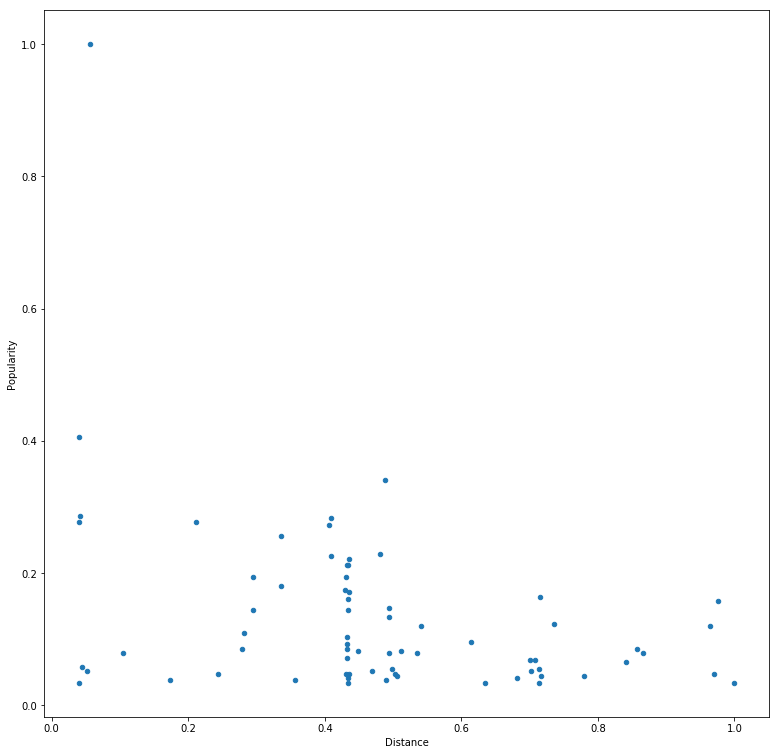

In [31]:
columns = ["Distance", "Popularity"]

plot_data = retailers_grouped[["Popularity", "Distance"]] # pull out the relevant two columns

plot_data = plot_data.reindex(columns = columns)

plot_data.plot(kind = "scatter", x = "Distance", y = "Popularity", figsize=(13, 13))  # plot the data as a scatter plot

plt.xlabel("Distance")
plt.ylabel("Popularity")

plt.show()

### Machine learning ###

The datapoints here are very scattered. We would benefit from knowing which points might be most relevant.

Under the assumption that the hypothetical perfect business would be extremely popular but with its nearest retail presence very far away from Northwich - a score of [1.0, 1.0] on the above figure - we can use that as our target.

Using the K Means algorithm with the four extremes as the starting centroids, we can cluster to find data points that are:

- popular and distant
- popular and close
- unpopular and distant
- unpopular and close

In [32]:
from sklearn.cluster import KMeans

In [33]:
starting_centres = np.ndarray(shape = (4, 2), buffer = np.array([[1.0, 1.0], [0, 0], [0, 1.0], [1.0, 0]]), dtype = float) # generate an ndarray with the four corners as values

starting_centres

array([[ 1.,  1.],
       [ 0.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]])

In [34]:
k_means = KMeans(init = starting_centres, n_clusters = 4, n_init = 1) # generate the K Means model

In [35]:
X = plot_data.values # extract the values in a format the model can use

k_means.fit(X) # fit the model with the data

KMeans(algorithm='auto', copy_x=True,
    init=array([[ 1.,  1.],
       [ 0.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]]),
    max_iter=300, n_clusters=4, n_init=1, n_jobs=1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [36]:
k_means.labels_ # check the labels that have been assigned by the model

array([2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 3, 0,
       1, 0, 0, 3, 0, 3, 1, 0, 0, 0, 3, 0, 1, 0, 0, 3, 0, 0, 1, 0, 3, 3, 3,
       1, 3, 0, 1, 3, 0, 3, 0, 0, 0, 1, 3, 0, 3, 3, 0, 1, 0, 0, 3, 3, 1, 3,
       0], dtype=int32)

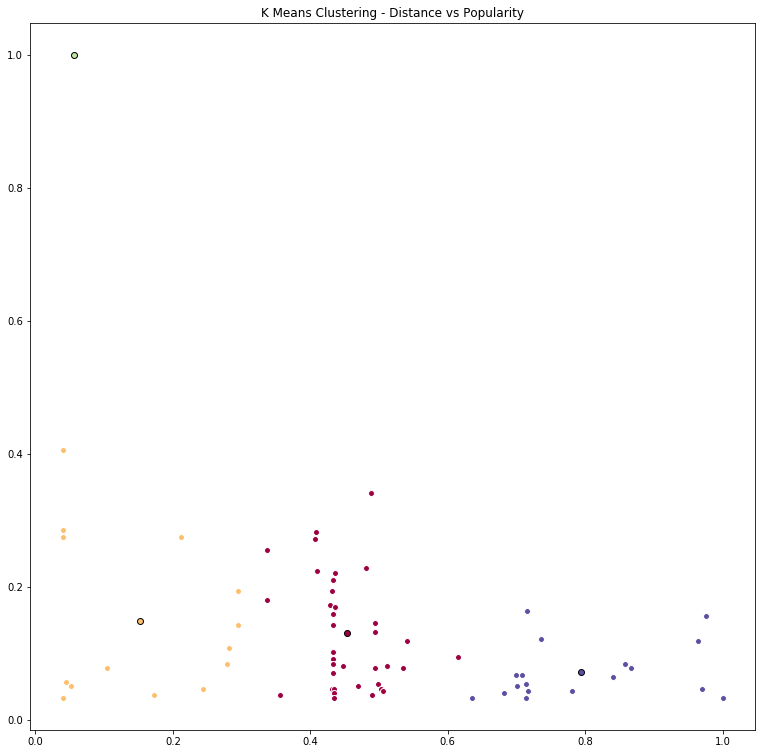

In [37]:
k_means_labels = k_means.labels_ # assign to a variable
k_means_cluster_centres = k_means.cluster_centers_ # set the centroids to a variable

fig = plt.figure(figsize = (13, 13)) # initialise a figure

colours = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels)))) # generate colours for the number of clusters

ax = fig.add_subplot(1, 1, 1) # add a subplot to the figure

for k, col in zip(range(len([[1.0, 1.0], [0, 0], [0, 1.0], [1.0, 0]])), colours):

    my_members = (k_means_labels == k) # create a list of points in the same cluster
    
    cluster_centre = k_means_cluster_centres[k] # define the centre of the cluster
    
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor = col, marker = "o") # plot points with colour
    
    ax.plot(cluster_centre[0], cluster_centre[1], "o", markerfacecolor = col,  markeredgecolor = "k", markersize = 6) # plot centroids with colour and outline

ax.set_title("K Means Clustering - Distance vs Popularity") # set title

plt.show() # show the plot

The central group, classification 0, shows an adequate balance of popularity and distance. These should be the first retailers that Cheshire West and Chester Council approach as potential tentants.

If we add these classifications to the dataframe and liimit to classification 0, we'll have our target dataframe.

In [38]:
retailers_grouped["Classification"] = k_means.labels_ # add the classification as a new column

In [39]:
Prospective_Retailers = retailers_grouped[retailers_grouped["Classification"] == 0].reset_index(drop = True) # cut out 0 cluster only

While all the top retailers are worth investigating, it could be beneficial to attribute a "score" to each row. A sum of the normalised distance and popularity values will give a value somewhere between 0 and 2.

In [40]:
Prospective_Retailers["Score"] = Prospective_Retailers["Popularity"] + Prospective_Retailers["Distance"]

We can then sort high-low with this new score, drop unnecessary columns, and reset the index to give a tidy final dataframe.

In [41]:
Prospective_Retailers.sort_values("Score", ascending = False, inplace = True) # sort descending by Score

Prospective_Retailers.drop(columns = ["Popularity", "Distance", "Classification"], inplace = True) # remove Popularity, Distance and Classification

Prospective_Retailers.reset_index(drop = True, inplace = True) # re-index to remove gaps

Prospective_Retailers # show the final dataframe

,Retailer,Count,Closest,Score
0,LLOYDSPHARMACY,100,17096.0,0.829740
1,ONE STOP STORES LTD,28,21502.0,0.709888
2,HOME BARGAINS,67,16815.0,0.709084
3,TK MAXX,83,14298.0,0.691779
4,WILKO,80,14235.0,0.679740
5,TOPMAN,35,18929.0,0.660267
6,VISION EXPRESS,65,15248.0,0.657488
7,PRIMARK,62,15171.0,0.645049
8,VODAFONE,62,15156.0,0.644620
9,F&F CLOTHING,43,17284.0,0.640572


In [42]:
Prospective_Retailers.to_csv(path_or_buf = "Prospective_Retailers.csv") # save the final file